Pushrim Kinetics
===============
The [pushrimkinetics](api/ktk.pushrimkinetics.rst) module allows processing kinetics data from instrumented wheelchair wheels such as the SmartWheel.

In [1]:
import ktk
import matplotlib.pyplot as plt

Read data from file
-------------------
The first step is to load data from a file, using the `read_file` function.

In [2]:
filename = ('data/pushrimkinetics/'
            'sample_swl_overground_propulsion_withrubber.csv')

kinetics = ktk.pushrimkinetics.read_file(filename)

Let see what we loaded:

In [3]:
kinetics

TimeSeries with attributes:
             data: <dict with 5 entries>,
        data_info: <dict with 4 entries>,
           events: <list of 0 items>,
             time: <array of shape (7682,)>,
        time_info: <dict with 1 entries>

In [4]:
kinetics.data

{
         'Angle': <array of shape (7682,)>,
      'Channels': <array of shape (7682, 6)>,
        'Forces': <array of shape (7682, 4)>,
         'Index': <array of shape (7682,)>,
       'Moments': <array of shape (7682, 4)>
}

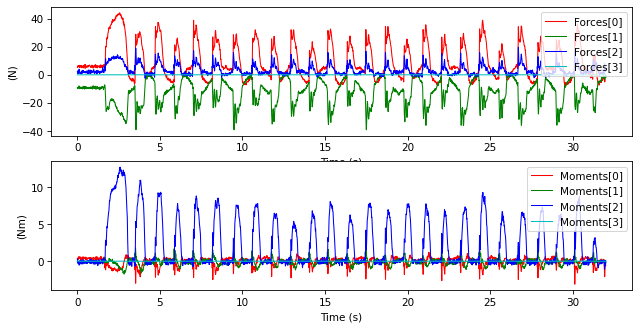

In [5]:
plt.subplot(2, 1, 1)
kinetics.plot('Forces')
plt.subplot(2, 1, 2)
kinetics.plot('Moments')

Calculate forces and moments
----------------------------
If the data is not in a CSV form but instead in a TXT file from the SmartWheel's SD card, we can also read this file, by specifying the `smartwheeltxt` format in `read_file`. However, in this case, the file contains only the raw channels, index and angle. In this case, we must calculate the forces and moments based on a calibration matrix. The function `calculate_forces_and_moments` does this calculation and already includes calibration matrices based on SmartWheels' serial numbers. For example:

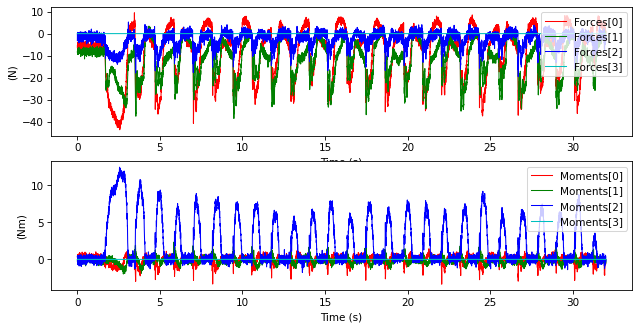

In [6]:
new_kinetics = ktk.pushrimkinetics.calculate_forces_and_moments(
    kinetics, 'LIO-123')

plt.subplot(2, 1, 1)
new_kinetics.plot('Forces')
plt.subplot(2, 1, 2)
new_kinetics.plot('Moments')

When the forces and moments are reconstructed from raw data, no modification
has been applied on the signals by the SmartWheel software to account for
wheel side. Therefore some signals may be inverted, as observed here.

Removing sinusoids in forces and moments
----------------------------------------
We observe in the last graphs that sinusoidal offsets are presents mostly in the forces but also in the moments. We can auto-remove these offsets using `remove_sinusoids`.

Let's apply this function on the data we just loaded.

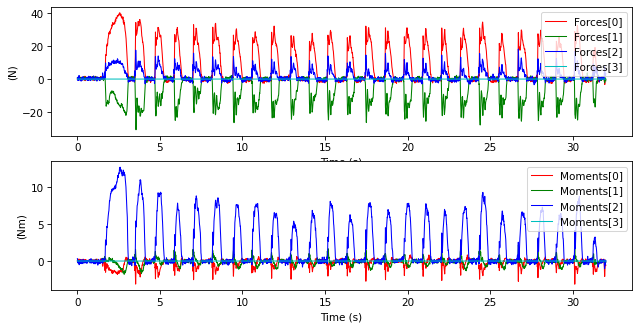

In [7]:
kinetics = ktk.pushrimkinetics.remove_sinusoids(kinetics)

plt.subplot(2, 1, 1)
kinetics.plot('Forces')
plt.subplot(2, 1, 2)
kinetics.plot('Moments')

This automatic method has only be validated for straight-line, level-ground propulsion. For any other condition, a baseline trial is required. A baseline trial is a trial where an operator pushes the wheelchair but no external
force appart from gravity is applied on the instrumented wheel. For example:

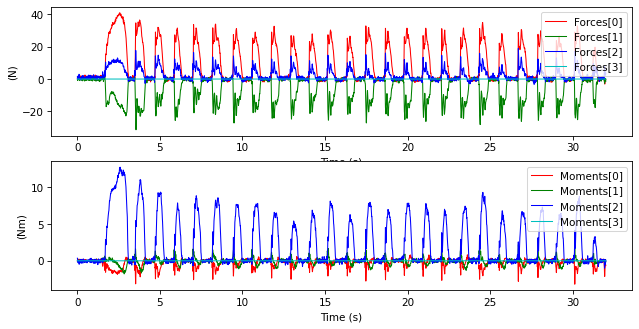

In [8]:
kinetics = ktk.pushrimkinetics.read_file(
        'data/pushrimkinetics/sample_swl_overground_propulsion_withrubber.csv')

baseline = ktk.pushrimkinetics.read_file(
        'data/pushrimkinetics/sample_swl_overground_baseline_withrubber.csv')

kinetics = ktk.pushrimkinetics.remove_sinusoids(kinetics, baseline)

plt.subplot(2, 1, 1)
kinetics.plot('Forces')
plt.subplot(2, 1, 2)
kinetics.plot('Moments')

Calculate velocity and power
----------------------------
Thee wheel velocity is calculated from the wheel angle with a derivative Savitsky-Golay filter, using the `calculate_velocity` function. Once the velocity has been calculated, the output power can also be calculated by
multiplying the velocity by the propulsion moment, using the `calculate_power` function.

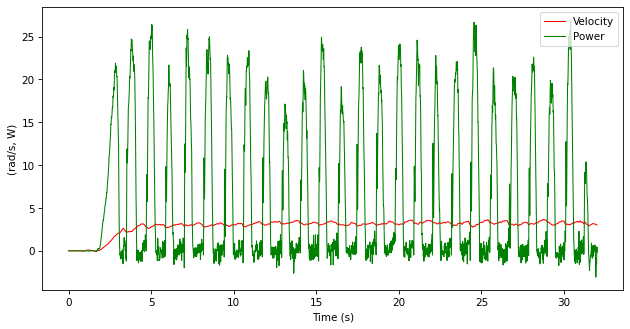

In [9]:
kinetics = ktk.pushrimkinetics.calculate_velocity(kinetics)
kinetics = ktk.pushrimkinetics.calculate_power(kinetics)

kinetics.plot(['Velocity', 'Power'])

Detecting pushes
----------------

The function ``detect_pushes`` allows detecting pushes and recoveries
automatically based on a double-threshold.

In [10]:
kinetics = ktk.pushrimkinetics.detect_pushes(kinetics)

kinetics

TimeSeries with attributes:
             data: <dict with 7 entries>,
        data_info: <dict with 6 entries>,
           events: <list of 75 items>,
             time: <array of shape (7682,)>,
        time_info: <dict with 1 entries>

We see that the TimeSeries now has 75 events, which are:

- 25 push starts named 'push'
- 25 recovery starts named 'recovery'
- 25 cycle ends named '_': By convention, this special event always refer to the end of a given cycle.

Let's see these events on a plot.

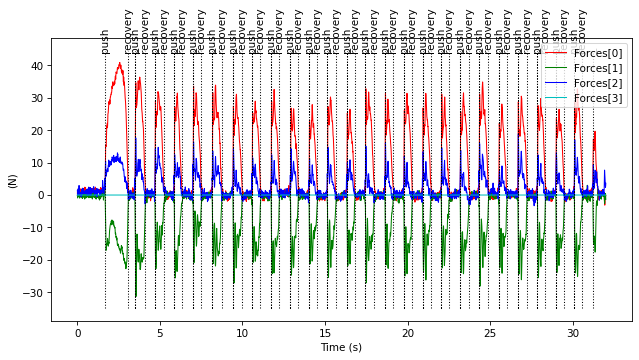

In [11]:
kinetics.plot('Forces')

Time-normalizing data
---------------------

Now, we may be intested in time-normalizing our pushes. For example, if we are interested to find the average progression of the push force.

Time-normalizing is not specific to the ktk.pushrimkinetics module, it is in the [ktk.cycles module](api/ktk.cycles.rst). See this [ktk.cycle's module tutorial](cycles.rst) for more details.

To analyze complete cycles, we may time-normalize each cycle from the `push` event to the next `push` event.

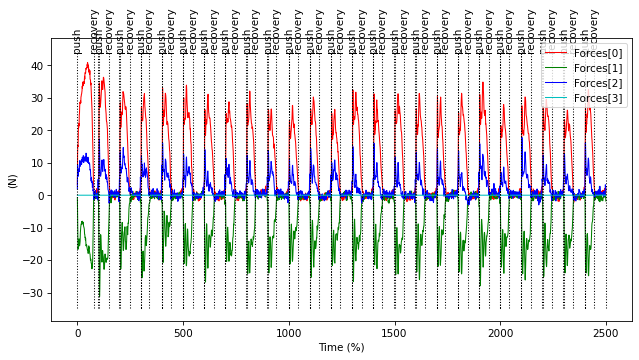

In [12]:
normalized_kinetics = ktk.cycles.time_normalize(kinetics, 'push', '_')
normalized_kinetics.plot('Forces')

To analyze the push phase, we instead want to time-normalize each push from the `push` event to the `recovery` event.

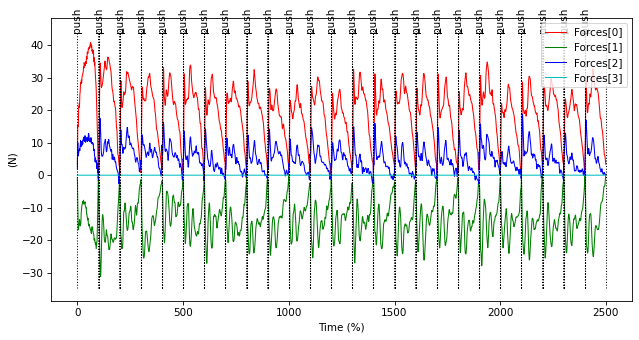

In [13]:
normalized_kinetics = ktk.cycles.time_normalize(kinetics, 'push', 'recovery')
normalized_kinetics.plot('Forces')

It is now possible to extract each push in a [cycle, percent, component] shape, using the [ktk.cycles.stack_normalized_data](api/ktk.cycles.rst#ktk.cycles.stack_normalized_data) method.

In [14]:
data = ktk.cycles.stack_normalized_data(normalized_kinetics)

data

{
         'Angle': <array of shape (25, 100)>,
      'Channels': <array of shape (25, 100, 6)>,
        'Forces': <array of shape (25, 100, 4)>,
         'Index': <array of shape (25, 100)>,
       'Moments': <array of shape (25, 100, 4)>,
         'Power': <array of shape (25, 100)>,
      'Velocity': <array of shape (25, 100)>
}

Plot the normalized force curves one on top of each other:

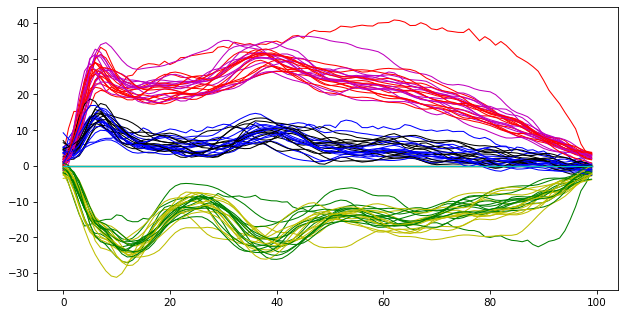

In [15]:
for i in range(data['Forces'].shape[0]):
    plt.plot(data['Forces'][i])

For more information on pushrimkinetics, please check the [API Reference](api/ktk.pushrimkinetics.rst).